# **User signups and feature importances with Light Gradient Boosting Machine (LGBM).**

The data has the following two tables:

1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

● name: the user's name<br>
● object_id: the user's id<br>
● email: email address<br>
● creation_source: how their account was created.<br> This takes on one
of 5 values:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;○ PERSONAL_PROJECTS: invited to join another user's personal workspace<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;○ GUEST_INVITE: invited to an organization as a guest (limited permissions)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;○ ORG_INVITE: invited to an organization (as a full member)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;○ SIGNUP: signed up via the website<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;○ SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)<br>
● creation_time: when they created their account<br>
● last_session_creation_time: unix timestamp of last login<br>
● opted_in_to_mailing_list: whether they have opted into receiving<br>
marketing emails<br>
● enabled_for_marketing_drip: whether they are on the regular
marketing email drip<br>
● org_id: the organization (group of users) they belong to<br>
● invited_by_user_id: which user invited them to join (if applicable).<br>
2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-­day period, **identify which factors predict future user adoption.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import datetime
import seaborn as sns
import scipy
from google.colab import files
from scipy.stats import randint
import pprint
import random
import time
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
style.use('seaborn-bright')

Now, we will upload files to Google Colab Pro and assign variables to the files.  We will use Google Colab Pro because we will use Randomized Search to try to identify best parameters of a Light Gradient Boosting Machine model.  This could be computationally expensive but we can iterate through a range of possible values.

In [2]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving takehome_users.csv to takehome_users.csv


In [3]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving takehome_user_engagement.csv to takehome_user_engagement.csv


In [4]:
df = pd.read_csv('takehome_users.csv', encoding='latin')
dff = pd.read_csv('takehome_user_engagement.csv')

## **Exploratory Data Analysis**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
df.shape

(12000, 10)

It looks like we have 12,000 observations and 10 features to work with initially.  Will this be enough for XGBoost?  We will find out.  It also looks like we have missing values in last_session_creation_time and invited_by_user_id so we will have to deal with them accordingly.  

In [7]:
df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [8]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Everything looks straight forward except the creation time definitely needs to be a datetime column.

## **Data Cleaning and Manipulation**

In [9]:
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


Looks like that worked as the creation_time is now a datetime64 type. Let's check out our other data file.

In [11]:
dff.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [12]:
dff.shape

(207917, 3)

That is a lot of observations.  Only 3 columns though.

In [13]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Looks like there are no missing values here.  The time_stamp is an object though.

In [14]:
dff.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


This is interesting.  Every value in the visited column is a 1?  The user_id column appears to be sorted by user_id as it is chronological and rather symmetric although not exactly as the mean is different than the 50% indicator but they are not off by much.  From the brief provided, we are "defining an *adopted user* as a user who has logged into the product on three separate days in at least one seven­-day period."  Therefore, the first login time and last login time must be a minimum of one week apart.

In [15]:
dff['time_stamp'] = pd.to_datetime(dff['time_stamp'])
dff.sort_values(by=['user_id', 'time_stamp'], inplace=True)

We will now join the two data frames of df with only the object_id and dff together and call it *counter*.  A left join would be most appropriate as only the values in dff that are in df would be in counter.

In [16]:
counter = dff.groupby(by=['user_id']).count()[['visited']]

user_id = df[['object_id']].copy()
user_id.set_index('object_id', inplace=True)

counter = user_id.join(counter, how='left').fillna(0)

In [17]:
counter['adopted'] = np.nan
counter.loc[counter.visited < 3, 'adopted'] = 0

In [18]:
counter.head()

,visited,adopted
object_id,,
1,1.0,0.0
2,14.0,NaN
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0


Now, we want to put those user ids that are nulls to a list.

In [19]:
users_w_3 = counter[counter.adopted.isnull()].index.values.tolist()

Tset is the user_ids that are in the users with 3 consecutive days.

In [20]:
tset = dff[dff.user_id.isin(users_w_3)].copy()

In [21]:
def ranger(x):
    return (max(x) - min(x))

The ranger function finds the range of values between the minimum and maximum and will be applied to all user's timestamps.

In [22]:
span = tset.groupby('user_id')['time_stamp'].apply(ranger)

In [23]:
span.describe()

count                           2248
mean     226 days 04:09:10.889679716
std      209 days 01:43:24.737490084
min                  3 days 00:00:00
25%                 51 days 00:00:00
50%                139 days 00:00:00
75%                363 days 00:00:00
max                727 days 00:00:00
Name: time_stamp, dtype: object

The minimum is 3 days, so some users who used the product 3 or more times did so only over 3 days. These users must be excluded. The line below should exclude some users from the adopted users.

In [24]:
adopters = span[span >= '7 days'].index.tolist()

In [25]:
tset['time_stamp'] = tset['time_stamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))

In [26]:
tset.head(20)

,time_stamp,user_id,visited
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1
5,2013-12-31,2,1
6,2014-01-08,2,1
7,2014-02-03,2,1
8,2014-02-08,2,1
9,2014-02-09,2,1
10,2014-02-13,2,1


In [27]:
min(tset.groupby('user_id')['time_stamp'].nunique().sort_values())

3

This means that every user with three or more rows logged in on at least 3 separate days because this is the minimum.  We can conclude that the adopters set does indeed include all of the adopted users and we do not need to break the list down any further. We will set their adopted values to 1.

In [28]:
counter.loc[counter.index.isin(adopters), 'adopted'] = 1

In [29]:
counter[counter.adopted.isnull()]

,visited,adopted
object_id,,
3059,3.0,NaN
3222,3.0,NaN
3638,3.0,NaN
4093,3.0,NaN
4396,3.0,NaN
5970,3.0,NaN
6981,3.0,NaN
10277,3.0,NaN


If we slice "adopters" in *span*, which are the users in span with less than 7 days, the list should be identical.

In [30]:
span[span < '7 days'].index.tolist()

[3059, 3222, 3638, 4093, 4396, 5970, 6981, 10277]

We will now set the rest of the users with a 0 'adopted' value.

In [31]:
counter.loc[counter.index.isin(span[span < '7 days'].index.tolist()), 'adopted'] = 0

In [32]:
counter.adopted.value_counts()

0.0    9760
1.0    2240
Name: adopted, dtype: int64

It appears as if the data has much more 0 than 1 but this should not be an issue with XGBoost.  Time for one more join.  We will join the adopted and visited columns to df to create one data frame for modeling purposes.

In [33]:
df.set_index('object_id', inplace=True)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [34]:
df = df.join(counter)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   float64       
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   visited                     12000 non-null  float64       
 10  adopted                     12000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)


The join was successful but we still have some missing values to deal with.  The last_session_creation_time is a unix timestamp of last login and a null value would indicate that they did not create a session.  We will set these null values to zero.

In [36]:
df.loc[df.last_session_creation_time.isnull(), 'last_session_creation_time'] = 0

Time to prepare the new dataframe for modeling.  XGBoost is otherwise known as Extreme Gradient Boosting and produces the most accurate models in the machine learning world.  XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.  Decision trees can handle imbalanced data, outliers, different data types, and classifies well.  They just have poor predictive power and are sensitive to variance.  XGBoost gets around the poor predictive power and sensitivity with several gradient boosted trees.  XGBoost also has a plot importance function which allows us to determine which features are most critical to the target which is whether a user will become an adopted user. We will drop the 'visited' column because we used it to create the target and the name and email columns as they should not have a bearing on prediciton.

In [37]:
df.drop(labels=['name', 'email', 'visited'], axis=1, inplace=True)

Next, we must change the creation_time to numeric for modeling.

In [38]:
first_date = min(df.creation_time)

In [39]:
new_creation_time = df.creation_time - first_date

In [40]:
df.creation_time = new_creation_time.dt.total_seconds()

In [41]:
df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,
1,59713803.0,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
2,46062097.0,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
3,25309885.0,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
4,30698761.0,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
5,19992653.0,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


Things are looking good but we still have one categorical variable, creation_source, which could have influence over the target.  Let's see how many values it has?

In [42]:
df.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

Not too many, only 5 so we can one-hot encode this variable.

In [43]:
df = pd.get_dummies(df, columns=['creation_source'])

The toughest choice here would be how to deal with the invided_by_user_id because it has missing values.  These missing values probably just mean that the user was not invited by a present user.  But, it may contain mistakes or omissions.  There are too many to drop as we would lose almost half of our data set but that could also be a mistake meaning that all users in the data set were referred making the entire column useless unless a particular user had influence over certain adopted users.  The best thing to do then is set the missing values to zero and see if users that were invited or not is an important feature to the target.  

In [44]:
df.loc[df.invited_by_user_id.isnull(), 'invited_by_user_id'] = 0

In [45]:
# move 'adopted' to the end
col_at_end = ['adopted']
df = df[[c for c in df if c not in col_at_end]
       + [c for c in col_at_end if c in df]]

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   creation_time                       12000 non-null  float64
 1   last_session_creation_time          12000 non-null  float64
 2   opted_in_to_mailing_list            12000 non-null  int64  
 3   enabled_for_marketing_drip          12000 non-null  int64  
 4   org_id                              12000 non-null  int64  
 5   invited_by_user_id                  12000 non-null  float64
 6   creation_source_GUEST_INVITE        12000 non-null  uint8  
 7   creation_source_ORG_INVITE          12000 non-null  uint8  
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 9   creation_source_SIGNUP              12000 non-null  uint8  
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
 11  adopted                             12000

Looks like the data set is ready for modeling as all of the values are numeric and there are no more missing values. We will start by splitting the data set while stratifying the split to compensate for inbalances.

## **Modeling**

In [47]:
X = df.drop(['adopted'], axis=1)
y = df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2346, stratify=y)

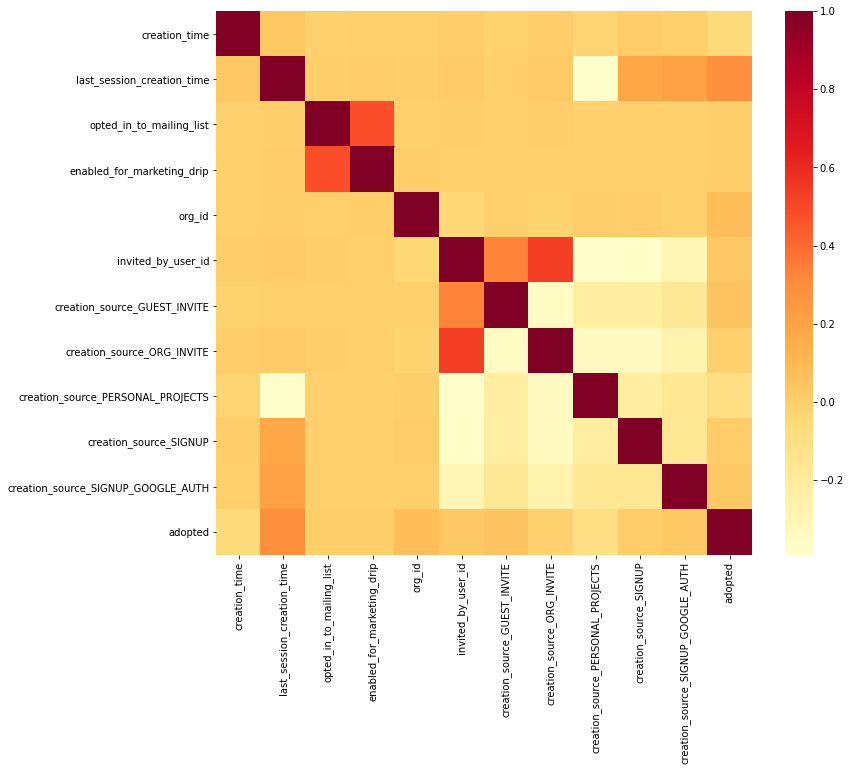

In [48]:
f, ax = plt.subplots(figsize=(12, 10))
corr = df.corr()
ax = sns.heatmap(corr, cmap = 'YlOrRd')
plt.show()

There looks to be quite a few strong correlations that make sense like guest invite creation source and invited_by_user_id.  Fortunately, LightGBM is good at handling data sets with a great deal of correlations. As far as the target goes, only one feature apears to have a fairly high correlation and that is last_session_creation_time.  LightGBM, short for Light Gradient Boosting Machine, is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38f7805d50>,
      dtype=object)

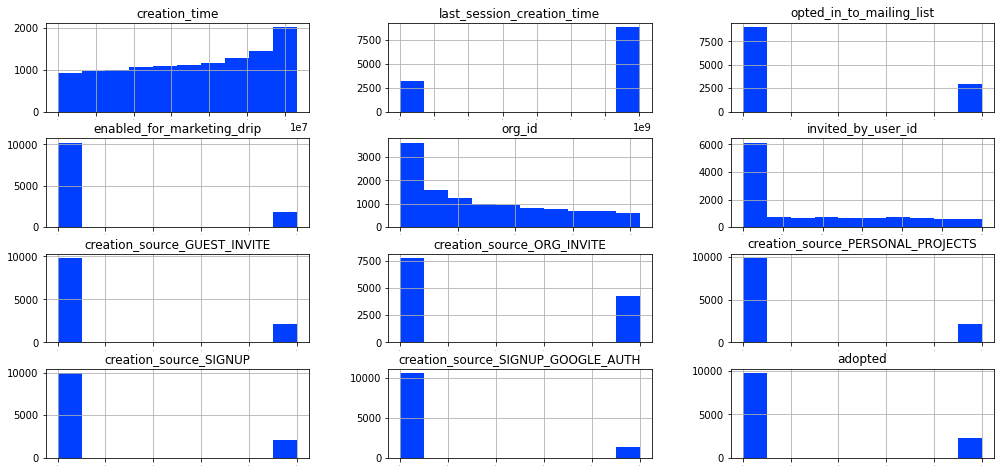

In [49]:
df.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8))

As I expected, most features are not following a normal distribution. Because LightGBM is a tree model at it's core, we will not have to normalize or scale the data.  Let's see how LightGBM handles this data.

In [50]:
model = lgb.LGBMClassifier()

To use the cv function, we first need to make a LightGBM dataset.

In [51]:
train_set = lgb.Dataset(data = X_train, label = y_train)
test_set = lgb.Dataset(data = X_test, label = y_test)

Now, we will create an objective function.  Here is where we employ early stopping, which is common in neural networks or gradient boosting algorithms because we let the algorithm tell us when the training error does not decrease for a specified number of iterations. This reduces variance and thus, overfitting.  This function also allows us to perform cross validation with the cv function. We will perform 5-fold cross-validation here.

In [52]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = 5, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 2346)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

We will now define our hyperparameter space below:

In [53]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

We will need our own randomized search function so that we can take advantage of using multiple iterations to increase the likelihood of finding the best model.  This function will return the best validation score and best hyperparameters.

In [56]:
def random_search(param_grid, max_evals = 10):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(max_evals)))
    
    # Keep searching until reach max evaluations
    for i in range(max_evals):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

Now, we are ready to take a look at the validation accuracy and the best hyperparameters.  We will save the best hyperparameters as random_search_params and apply them to a Light Gradient Boosting Machine Classifier and fit the model.

In [58]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.99668

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8666666666666667,
 'is_unbalance': True,
 'learning_rate': 0.027778881111994384,
 'min_child_samples': 210,
 'n_estimators': 1101,
 'num_leaves': 109,
 'reg_alpha': 0.6326530612244897,
 'reg_lambda': 0.02040816326530612,
 'subsample': 0.5808080808080808,
 'subsample_for_bin': 160000}


In [59]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

In [60]:
new_model = lgb.LGBMClassifier(**random_search_params, random_state = 2346)

In [61]:
t0 = time.time()
new_model.fit(X_train, y_train)
ttt = time.time() - t0 # ttt - "time to train"
print("It took %.3f" % ttt, " seconds for Light Gradient Boosting Machine to fit the model")

y_pred = new_model.predict(X_test)

print("Accuracy with Light Gradient Boosting Machine on the test set is: %.5f" % new_model.score(X_test, y_test))

It took 5.826  seconds for Light Gradient Boosting Machine to fit the model
Accuracy with Light Gradient Boosting Machine on the test set is: 0.97500


That is an incredible accuracy! But, let's take a look at the training accuracy and compare the two.  It would be hard to imagine that there was overfitting with early stopping employed.

In [62]:
new_model.score(X_train, y_train)

0.9960185185185185

WOW! This is a good accuracy and the fact that the training set and test set accuracies are similar means that the training set was not overfit. Additionally, it took less than 6 seconds to train!  Let's take a look at feature importances of this model.

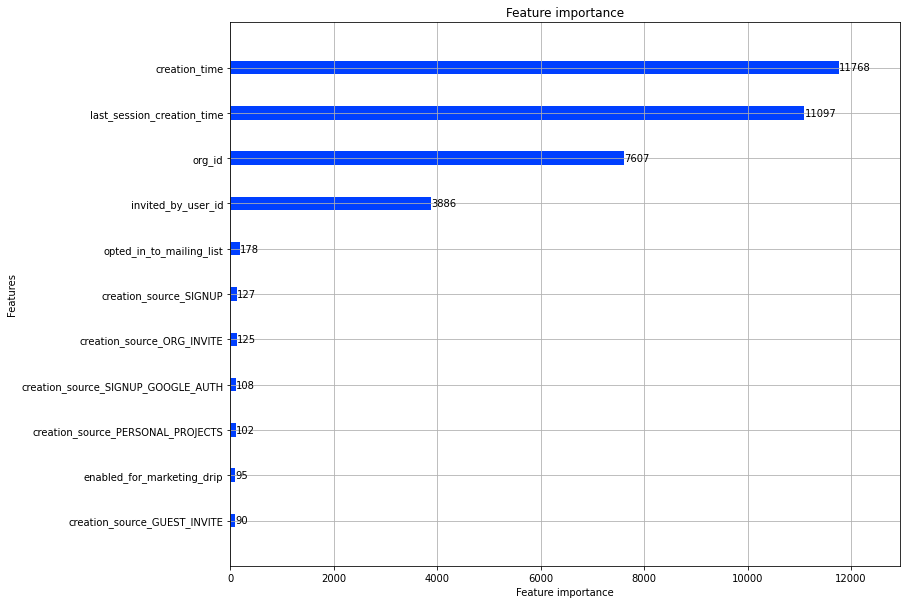

In [63]:
f, ax = plt.subplots(figsize=(12, 10))
lgb.plot_importance(new_model, height=0.3, ax=ax)

In [64]:
df.corr()['adopted'].sort_values()

creation_source_PERSONAL_PROJECTS    -0.092150
creation_time                        -0.057155
creation_source_ORG_INVITE           -0.005401
enabled_for_marketing_drip            0.007497
opted_in_to_mailing_list              0.008956
creation_source_SIGNUP                0.016040
invited_by_user_id                    0.030837
creation_source_SIGNUP_GOOGLE_AUTH    0.034449
creation_source_GUEST_INVITE          0.053546
org_id                                0.076437
last_session_creation_time            0.296935
adopted                               1.000000
Name: adopted, dtype: float64

As we can see, last_session_creation_time, org_id, invited_by_user_id and creation_time are the most influential features on the target.  The last_session_creation_time feature is also the most correlated with the target as well which mirrors the heatmap above.  This should come as no surprise as users who have logged in most recently are more likely to be adopted users or users who use this particular product.  The most significant finding is really about the other two features.  The organization and whether they were invited by a user are positively correlated with the target and are both somewhat important features.  It appears that certain organizations and users have a significant influence on whether a user will become adopted.  